In [15]:
import pandas as pd 
import numpy as np
import warnings
from collections import Counter
import re
from optbinning import OptimalBinning
from pandas.api.types import is_string_dtype
import graphviz
from graphviz import nohtml

### 1- Building the decision Tree 

In [2]:
class Node: 
    def __init__(
        self, 
        Y: list,
        X: pd.DataFrame,
        min_samples_split=None,
        max_depth=None,
        depth=None,
        node_type=None,
        rule=None,
        stop=None,
        dataframe_constraints= pd.DataFrame([[0,0,0,0]]).rename(columns={0:"path",1:"feature",2:"type_feature", 3:"forced_value"}),
        path=''
    ): 
        self.Y = Y 
        self.X = X
        
        self.min_samples_split = min_samples_split if min_samples_split else 500
        self.max_depth = max_depth if max_depth else 5

        self.depth = depth if depth else 0

        self.features = list(self.X.columns)
        self.features_types = self.X.dtypes.apply(lambda x : "categorical" if is_string_dtype(x)  else "numerical").tolist()
        self.list_features = list(zip(self.features, self.features_types))

        self.node_type = node_type if node_type else 'root'

        self.rule = rule if rule else ""

        self.counts = Counter(Y)

        counts_sorted = list(sorted(self.counts.items(), key=lambda item: item[1]))

        yhat = None
        y_prob = None 
        if len(counts_sorted) > 0:
            yhat = counts_sorted[-1][0]
            y_prob = np.mean(Y)

        self.yhat = yhat
        self.y_prob = y_prob

        self.n = len(Y)

        self.left = None 
        self.right = None 
        self.best_feature = None 
        self.best_value = None
        self.best_type = None
        
        self.stop = stop
        self.dataframe_constraints = dataframe_constraints
        self.path = path + str(self.depth)+self.node_type
        
    def best_split(self) -> tuple:
        """
        Given the X features and Y targets calculates the best split 
        for a decision tree
        """
        # Creating a dataset for spliting
        df = self.X.copy()
        df['Y'] = self.Y


        # Default best feature and split
        best_feature = None
        best_value = None
        best_type = None 
        number_level = self.depth
        list_scores = list()
        dataframe_constraints = self.dataframe_constraints[self.dataframe_constraints.feature.isin(self.features)]
        
        echantillon = dataframe_constraints[(dataframe_constraints.path == self.path)]

        if len(echantillon)>0:
            best_feature = echantillon.feature.values[0]
            feature_type = echantillon.type_feature.values[0]
            sous_ech_constraint = echantillon[((echantillon.forced_value!="") & (dataframe_constraints.type_feature=="categorical")) |((~dataframe_constraints.forced_value.isna()) & (dataframe_constraints.type_feature=="numerical"))]
            if len(sous_ech_constraint)>0:
                best_value = sous_ech_constraint.forced_value.values[0]
                best_type = feature_type

                return (best_feature, best_value, best_type)
            else:
                x = self.X[best_feature].values
                y = self.Y
                optb = OptimalBinning(name=best_feature, dtype=feature_type, solver="cp",max_n_bins = 2, min_bin_size = min(0.5, self.stop / len(df)))
                optb.fit(x, y)
                binning_table = optb.binning_table.build()
                binning_table = binning_table[~binning_table["Bin"].isin( ["Special","Missing"])]
                if len(binning_table)>2:
                    list_scores.append([number_level,best_feature,feature_type,
                        binning_table.loc[0, "Bin"], 
                        binning_table.loc[1, "Bin"],
                        binning_table.loc[1, "Count"],
                        binning_table.loc[0, "Count"],
                        binning_table.loc[0, "Event rate"],
                        binning_table.loc[1, "Event rate"]])
        else:       
            for feature, feature_type in self.list_features :
                x = self.X[feature].values
                y = self.Y
                optb = OptimalBinning(name=feature, dtype=feature_type, solver="cp",max_n_bins = 2, 
                                      min_bin_size = min(0.5, self.stop / len(df)))
                optb.fit(x, y)
                binning_table = optb.binning_table.build()
                binning_table = binning_table[~binning_table["Bin"].isin( ["Special","Missing"])]
                if len(binning_table)>2:
                    list_scores.append([number_level,feature,feature_type, 
                                        binning_table.loc[0, "Bin"], 
                                        binning_table.loc[1, "Bin"],
                                        binning_table.loc[1, "Count"],
                                        binning_table.loc[0, "Count"],
                                        binning_table.loc[0, "Event rate"], 
                                        binning_table.loc[1, "Event rate"]])
                
        dataframe_scores = pd.DataFrame(list_scores)
        if len(dataframe_scores) >0 :
            dataframe_scores = dataframe_scores.rename(columns={0:"level", 1:"feature", 2: "feature_type", 3:"bin_0",
                                                                4: "bin_1", 5:"count_0", 6: "count_1", 7:"event_rate_0", 8:"event_rate_1"})
            dataframe_scores['diff_rate'] = np.abs(dataframe_scores['event_rate_0']- dataframe_scores['event_rate_1'])
            max_dataframe_scores = dataframe_scores.groupby(['level'])['diff_rate'].max().reset_index().merge(dataframe_scores, how="left", on=['level', 'diff_rate'])
            best_feature = max_dataframe_scores['feature'].values[0]
            best_type = max_dataframe_scores['feature_type'].values[0]

            if best_type == "categorical":
                best_value = max_dataframe_scores['bin_0'].values[0]
            else:
                best_value = float(re.findall("\d+\.\d+", max_dataframe_scores["bin_0"].values[0])[0])

        return (best_feature, best_value, best_type)
    
    def grow_tree(self):
        df = self.X.copy()
        df['Y'] = self.Y
        if (self.depth < self.max_depth) and (self.n >= self.min_samples_split):
            best_feature, best_value, best_type = self.best_split()

            if best_feature is not None:
                # Saving the best split to the current node 
                self.best_feature = best_feature
                self.best_value = best_value
                self.best_type = best_type
                print(self.depth, best_feature,best_value, best_type )
                if self.best_type=="categorical":
                    left_df, right_df = df[df[best_feature].isin(best_value)].copy(), df[~df[best_feature].isin(best_value)].copy()
                    left = Node(left_df['Y'].values.tolist(), 
                                left_df[self.features], 
                                depth=self.depth + 1, 
                                max_depth=self.max_depth, 
                                min_samples_split=self.min_samples_split, 
                                node_type='left_node',
                                rule =" {best_feature} in {best_value} ".format(best_feature=best_feature, best_value = best_value),
                                stop = self.stop,
                                dataframe_constraints = self.dataframe_constraints,
                                path=self.path)
                    
                    self.left = left 
                    self.left.grow_tree()
                    
                    right = Node(
                        right_df['Y'].values.tolist(), 
                        right_df[self.features], 
                        depth=self.depth + 1, 
                        max_depth=self.max_depth, 
                        min_samples_split=self.min_samples_split,
                        node_type='right_node',
                        rule =" {best_feature} not in {best_value} ".format(best_feature=best_feature, best_value = best_value),
                        stop = self.stop,
                        dataframe_constraints = self.dataframe_constraints, 
                        path=self.path
                    )
                    
                    self.right = right
                    self.right.grow_tree()

                else:
                    left_df, right_df = df[df[best_feature]<=best_value].copy(), df[df[best_feature]>best_value].copy()
                    left = Node(left_df['Y'].values.tolist(), 
                                left_df[self.features], 
                                depth=self.depth + 1, 
                                max_depth=self.max_depth, 
                                min_samples_split=self.min_samples_split, 
                                node_type='left_node',
                                rule = f"{best_feature} <= {round(best_value, 3)}",
                                stop = self.stop, 
                                dataframe_constraints = self.dataframe_constraints, 
                                path=self.path)
                    
                    self.left = left 
                    self.left.grow_tree()
                    
                    right = Node(
                        right_df['Y'].values.tolist(), 
                        right_df[self.features], 
                        depth=self.depth + 1, 
                        max_depth=self.max_depth, 
                        min_samples_split=self.min_samples_split,
                        node_type='right_node',
                        rule =f"{best_feature}> {round(best_value, 3)}",
                        stop = self.stop,  
                        dataframe_constraints = self.dataframe_constraints, 
                        path=self.path)
                    
                    self.right = right
                    self.right.grow_tree()
                    
        
        
    def print_tree(self, result=None):
        
        if result is None:
            result = []
 
        dictionnaire = dict(self.counts)
        result.append([self.path, self.rule,dictionnaire, round(self.y_prob, 3), self.yhat])
        if self.left is not None: 
            self.left.print_tree(result=result)
        if self.right is not None:
            self.right.print_tree(result=result)
        return result
    
    
    def print_tree_dataframe(self):
        dataframe = pd.DataFrame(self.print_tree())
        dataframe = dataframe.rename(columns={0:"path",1:"rule",2:"distribution",3:"probabilite" ,4:"prediction"})
        return dataframe
    
    def create_plot_tree(self, result=None):
        
        if result is None:
            result = graphviz.Digraph('g', filename='btree.gv',
                                      node_attr={'shape': 'record', 'height': '.1'})
 
        dictionnaire = dict(self.counts)
        str_dictionnaire = str(dictionnaire).replace('{', '[').replace('}', ']')
        str_rule = self.rule.replace('>',' higher than ').replace('<=', " lower or equal than")
        result.node(str(self.path),
                    nohtml('<f0>|<f1> Distribution: {} \\n Probability = {} \\n Prediction ={} \\n Variable Rule: {}| <f2> '.format(str_dictionnaire,round(self.y_prob, 3),self.yhat,str_rule))) 
        if self.left is not None: 
            result.edge('{}:f0'.format(str(self.path)), '{}:f1'.format(str(self.left.path)))
            self.left.create_plot_tree(result=result)
        if self.right is not None:
            result.edge('{}:f2'.format(str(self.path)), '{}:f1'.format(str(self.right.path)))
            self.right.create_plot_tree(result=result)
        return result
    
    def plot_tree(self):
        self.create_plot_tree().view()


    def predict(self, X:pd.DataFrame):
        """
        Batch prediction method
        """
        predictions = []

        for _, x in X.iterrows():
            values = {}
            for feature in self.features:
                values.update({feature: x[feature]})
            
        
            predictions.append(self.predict_obs(values))
            
        predictions = pd.DataFrame(predictions)
        predictions = predictions.rename(columns={0:"prediction",1:"probability"})
        
        return predictions

    def predict_obs(self, values: dict) -> int:
        """
        Method to predict the class given a set of features
        """
        cur_node = self
        while (cur_node.depth < cur_node.max_depth) and (cur_node.best_feature is not None):
            # Traversing the nodes all the way to the bottom
            best_feature = cur_node.best_feature
            best_value = cur_node.best_value
            type_feature = cur_node.best_type

            if cur_node.n < cur_node.min_samples_split:
                break 
                
            
            if type_feature == "categorical":
                if (values.get(best_feature) in best_value ):
                    if self.left is not None:
                        cur_node = cur_node.left
                else:
                    if self.right is not None:
                        cur_node = cur_node.right
            else:
                if (values.get(best_feature) < best_value):
                    if self.left is not None:
                        cur_node = cur_node.left
                else:
                    if self.right is not None:
                        cur_node = cur_node.right
            
        return cur_node.yhat, round(cur_node.y_prob,3)

### 2- Loading the titanic data set

In [3]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

### 3- Choosing the features 

- Target : Survived
- Features : Sex, Cabin, Age, Fare, Pclass, Embarked

### 4- First case : No Constraints 

- We use all the features , and define a minimum proportion node of 3% of the population and a maximum depth of 4

In [4]:
# Defining the X and Y matrices
Y = df_train['Survived'].values
X = df_train[['Sex','Cabin','Age','Fare','Pclass','Embarked']]
# Saving the feature list 
features = list(X.columns)
nb_stop = np.ceil(len(df_train) * 0.03)


hp = {
    "max_depth": 4,
    "stop" : nb_stop
}

root = Node(Y, X, **hp)

In [5]:
root.grow_tree()

0 Cabin ['A10' 'B86' 'B94' 'C110' 'C111' 'C118' 'C124' 'C128' 'C30' 'C46' 'C49'
 'C82' 'C86' 'C87' 'C91' 'B82 B84' 'C95' 'D30' 'D46' 'D48' 'D50' 'D6'
 'E31' 'E38' 'E46' 'E58' 'E63' 'E77' 'F G63' 'F G73' 'F38' 'D26' 'B71' 'T'
 'B19' 'B38' 'B102' 'A7' 'A5' 'A36' 'A32' 'B37' 'A19' 'B30' 'A14' 'A24'
 'C22 C26' 'C123' 'G6' 'C23 C25 C27' 'C65' 'B51 B53 B55' 'C78' 'B22' 'C83'
 'E44' 'E67' 'B58 B60' 'C68' 'C2'] categorical
1 Fare 74.38 numerical
2 Sex ['male'] categorical
3 Pclass 1.5 numerical


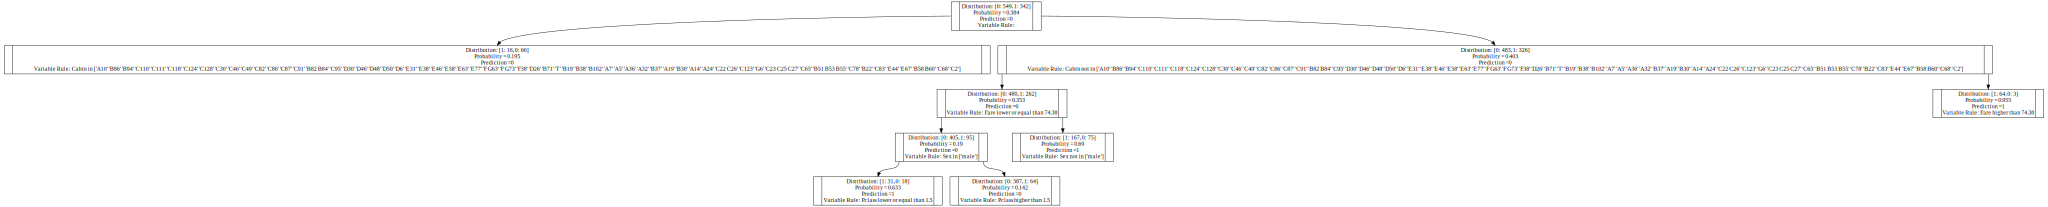

In [6]:
root.create_plot_tree()

- As you can see the first feature is the "Cabin" feature, now let's force the model to use another one, let's say for example Embarked 

### 5- Second case : Constraint of a variable in a node 

In [7]:
# Defining the X and Y matrices
Y = df_train['Survived'].values
X = df_train[['Sex','Cabin','Age','Fare','Pclass','Embarked']]
# Saving the feature list 
features = list(X.columns)
nb_stop = np.ceil(len(df_train) * 0.03)
list_constraints = [ ["0root",'Embarked',"categorical",""]]
dataframe_constraints = pd.DataFrame(list_constraints)
dataframe_constraints = dataframe_constraints.rename(columns={0:"path",1:"feature",2:"type_feature", 3:"forced_value"})
hp = {
    "max_depth": 4,
    "stop" : nb_stop,
    "dataframe_constraints": dataframe_constraints
}

root_2 = Node(Y, X, **hp)

In [8]:
root_2.grow_tree()

0 Embarked ['S' 'Q'] categorical
1 Cabin ['A14' 'C128' 'C30' 'C46' 'C87' 'C91' 'C95' 'D26' 'D30' 'D46' 'C124' 'D50'
 'E31' 'E38' 'E46' 'E58' 'E63' 'E77' 'F G63' 'F G73' 'F38' 'D6' 'C110' 'T'
 'A32' 'B102' 'A36' 'B51 B53 B55' 'B38' 'B71' 'A24' 'B19' 'A19' 'B94'
 'C22 C26' 'C78' 'B22' 'C2' 'C23 C25 C27' 'E44' 'C123' 'E67' 'G6' 'C83'] categorical
2 Pclass 1.5 numerical
3 Sex ['male'] categorical


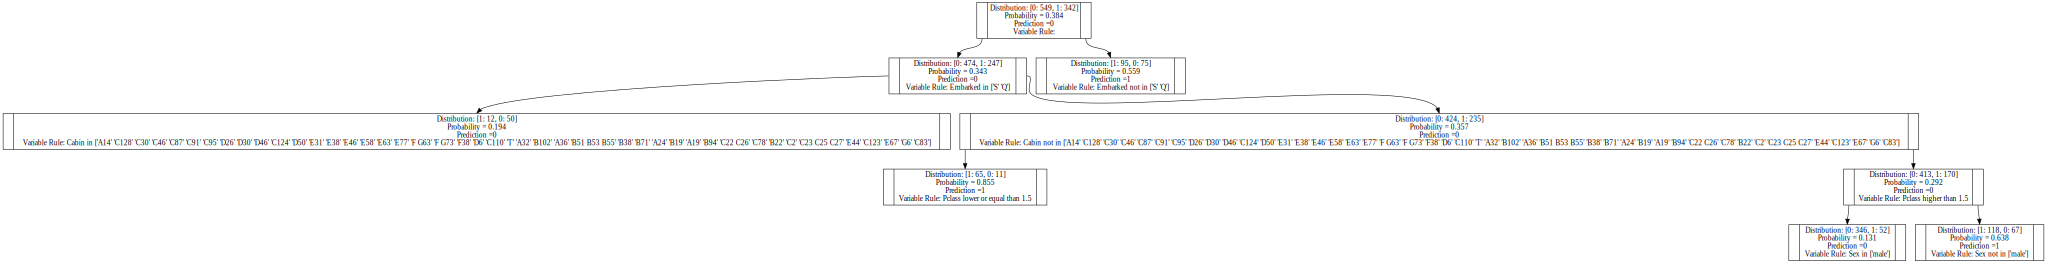

In [10]:
root_2.create_plot_tree()

We built a model with the following constraint : " Embarked must be the first feature in the tree"

- Let's use variable and value constraints , so we will force the model to use Embark feature as the first node and Pclass as the child node on the left with a numerical value split of 1.5

In [11]:
# Defining the X and Y matrices
Y = df_train['Survived'].values
X = df_train[['Sex','Cabin','Age','Fare','Pclass','Embarked']]
# Saving the feature list 
features = list(X.columns)
nb_stop = np.ceil(len(df_train) * 0.03)
list_constraints = [ ["0root",'Embarked',"categorical",""], ["0root1left_node",'Pclass',"numerical",1.5]]
dataframe_constraints = pd.DataFrame(list_constraints)
dataframe_constraints = dataframe_constraints.rename(columns={0:"path",1:"feature",2:"type_feature", 3:"forced_value"})
hp = {
    "max_depth": 4,
    "stop" : nb_stop,
    "dataframe_constraints": dataframe_constraints
}

root_3 = Node(Y, X, **hp)

In [12]:
root_3.grow_tree()

0 Embarked ['S' 'Q'] categorical
1 Pclass 1.5 numerical
2 Sex ['male'] categorical


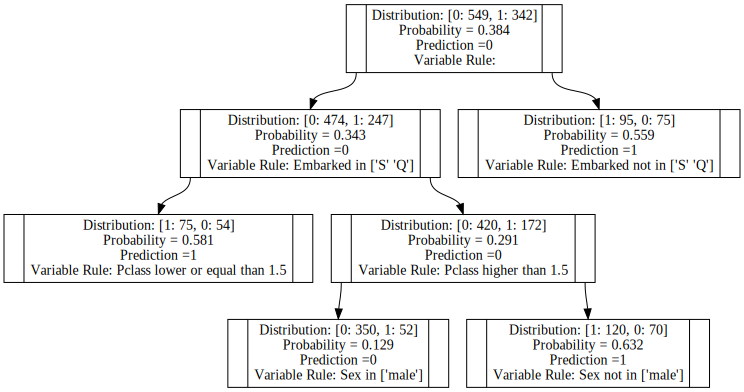

In [13]:
root_3.create_plot_tree()

We see that the first feature is Embark , and that the child on the left was the Pclass variable with a split value of 1.5

### To Summarize : 
We have designed a model:
- with no processing needed for categorical features.
- with the option of adding constraints on the structure of the tree in termes of: features and value splits. 

NB: The more you add constraints the less your model will be performant (no more optimized splits and optimized structure ) 

###  TODO: adding a gain function 